In [ ]:
import torch 
import torchvision 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim 
import torch.autograd as grad
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from drive.MyDrive.ColabNotebooks.model import Network, model_parameters
from __future__ import print_function

In [ ]:
# Transformations for Training Images
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.RandomAffine((10.0), fill=1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Transformations for Testing Images
test_transforms = transforms.Compose([                                    
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [ ]:
train = datasets.MNIST(root = './data', train = True, download = True, transform = train_transforms)
test = datasets.MNIST(root = './data', train = False, download = True, transform = test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
SEED = 1
cuda = torch.cuda.is_available()
if cuda:
  torch.manual_seed(SEED)
  device = torch.device('cuda')
else:
  device = torch.device('cpu')
data_loader_args = dict(shuffle = True, batch_size = 128, num_workers = 2, pin_memory = True) if cuda else dict(shuffle = True, batch_size = 64)
train_loader = DataLoader(train, **data_loader_args)
test_loader = DataLoader(test, **data_loader_args)

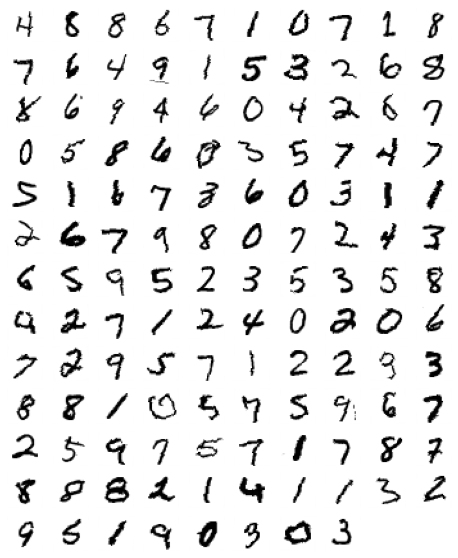

In [ ]:
batch = next(iter(train_loader))
images, labels = batch
fig = plt.figure(figsize=(8, 10))
for image_no in range(1, images.shape[0] + 1):
  plt.subplot(13, 10, image_no)
  plt.axis('off')
  plt.imshow(images[image_no - 1].numpy().squeeze(), cmap='gray_r')

In [ ]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, regularizer=False):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    if regularizer:
      lambda_scale = 0.0001
      l1 = 0
      for param in model.parameters():
        l1 += param.abs().sum()
      loss += lambda_scale * l1

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

def test(model, device, test_loader, test_losses, test_acc, incorrect_prediction):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            incorrect_preds = pred.ne(target.view_as(pred)).nonzero(as_tuple=True)[0]
            if len(incorrect_prediction) < 10 and len(incorrect_preds) > 0:
              for index in incorrect_preds:
                  incorrect_index = index.item()
                  incorrect_prediction.append([data[incorrect_index], pred[incorrect_index].item(), target.view_as(pred)[incorrect_index].item()])
                  if len(incorrect_prediction) > 10:
                      break
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

Model Summary

In [ ]:
model_parameters()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
            Conv2d-4           [-1, 16, 24, 24]           1,152
       BatchNorm2d-5           [-1, 16, 24, 24]              32
              ReLU-6           [-1, 16, 24, 24]               0
            Conv2d-7           [-1, 16, 22, 22]           2,304
         Dropout2d-8           [-1, 16, 22, 22]               0
       BatchNorm2d-9           [-1, 16, 22, 22]              32
             ReLU-10           [-1, 16, 22, 22]               0
           Conv2d-11            [-1, 8, 11, 11]             128
      BatchNorm2d-12            [-1, 8, 11, 11]              16
             ReLU-13            [-1, 8, 11, 11]               0
           Conv2d-14             [-1, 1

Training the Model using Layer Normalisation(Model 1)

In [ ]:
# Layer Normalisation
test_losses1 = []
test_acc1 = []
incorrect_prediction1 = []
model1 =  Network('LN').to(device)
optimizer = optim.SGD(model1.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
EPOCHS = 20
for epoch in range(1, EPOCHS+1):
    print("EPOCH:", epoch)
    train(model1, device, train_loader, optimizer)
    scheduler.step()
    test(model1, device, test_loader, test_losses1, test_acc1, incorrect_prediction1)

EPOCH: 1


Loss=0.2591782510280609 Batch_id=468 Accuracy=78.38: 100%|██████████| 469/469 [00:22<00:00, 20.75it/s]



Test set: Average loss: 0.1791, Accuracy: 9465/10000 (94.65%)

EPOCH: 2


Loss=0.15661408007144928 Batch_id=468 Accuracy=93.42: 100%|██████████| 469/469 [00:22<00:00, 20.55it/s]



Test set: Average loss: 0.0987, Accuracy: 9691/10000 (96.91%)

EPOCH: 3


Loss=0.1724650114774704 Batch_id=468 Accuracy=95.07: 100%|██████████| 469/469 [00:22<00:00, 20.71it/s]



Test set: Average loss: 0.1256, Accuracy: 9599/10000 (95.99%)

EPOCH: 4


Loss=0.07693176716566086 Batch_id=468 Accuracy=95.49: 100%|██████████| 469/469 [00:22<00:00, 20.61it/s]



Test set: Average loss: 0.0873, Accuracy: 9739/10000 (97.39%)

EPOCH: 5


Loss=0.0741477683186531 Batch_id=468 Accuracy=96.25: 100%|██████████| 469/469 [00:24<00:00, 19.18it/s]



Test set: Average loss: 0.0817, Accuracy: 9728/10000 (97.28%)

EPOCH: 6


Loss=0.04027369245886803 Batch_id=468 Accuracy=97.36: 100%|██████████| 469/469 [00:22<00:00, 20.53it/s]



Test set: Average loss: 0.0524, Accuracy: 9827/10000 (98.27%)

EPOCH: 7


Loss=0.09072792530059814 Batch_id=468 Accuracy=97.45: 100%|██████████| 469/469 [00:22<00:00, 20.55it/s]



Test set: Average loss: 0.0490, Accuracy: 9833/10000 (98.33%)

EPOCH: 8


Loss=0.11223763227462769 Batch_id=468 Accuracy=97.50: 100%|██████████| 469/469 [00:22<00:00, 20.54it/s]



Test set: Average loss: 0.0494, Accuracy: 9843/10000 (98.43%)

EPOCH: 9


Loss=0.05261816456913948 Batch_id=468 Accuracy=97.52: 100%|██████████| 469/469 [00:22<00:00, 20.50it/s]



Test set: Average loss: 0.0490, Accuracy: 9848/10000 (98.48%)

EPOCH: 10


Loss=0.04016217961907387 Batch_id=468 Accuracy=97.64: 100%|██████████| 469/469 [00:22<00:00, 20.41it/s]



Test set: Average loss: 0.0469, Accuracy: 9856/10000 (98.56%)

EPOCH: 11


Loss=0.10143875330686569 Batch_id=468 Accuracy=97.65: 100%|██████████| 469/469 [00:24<00:00, 18.92it/s]



Test set: Average loss: 0.0465, Accuracy: 9855/10000 (98.55%)

EPOCH: 12


Loss=0.041821446269750595 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:22<00:00, 20.44it/s]



Test set: Average loss: 0.0461, Accuracy: 9858/10000 (98.58%)

EPOCH: 13


Loss=0.07664375007152557 Batch_id=468 Accuracy=97.64: 100%|██████████| 469/469 [00:22<00:00, 20.43it/s]



Test set: Average loss: 0.0462, Accuracy: 9858/10000 (98.58%)

EPOCH: 14


Loss=0.0336013063788414 Batch_id=468 Accuracy=97.79: 100%|██████████| 469/469 [00:23<00:00, 20.34it/s]



Test set: Average loss: 0.0463, Accuracy: 9857/10000 (98.57%)

EPOCH: 15


Loss=0.07777906954288483 Batch_id=468 Accuracy=97.76: 100%|██████████| 469/469 [00:22<00:00, 20.41it/s]



Test set: Average loss: 0.0459, Accuracy: 9859/10000 (98.59%)

EPOCH: 16


Loss=0.0871276780962944 Batch_id=468 Accuracy=97.68: 100%|██████████| 469/469 [00:22<00:00, 20.41it/s]



Test set: Average loss: 0.0458, Accuracy: 9858/10000 (98.58%)

EPOCH: 17


Loss=0.08527174592018127 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:24<00:00, 19.05it/s]



Test set: Average loss: 0.0458, Accuracy: 9857/10000 (98.57%)

EPOCH: 18


Loss=0.04000624269247055 Batch_id=468 Accuracy=97.76: 100%|██████████| 469/469 [00:22<00:00, 20.40it/s]



Test set: Average loss: 0.0457, Accuracy: 9860/10000 (98.60%)

EPOCH: 19


Loss=0.0787571594119072 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:22<00:00, 20.43it/s]



Test set: Average loss: 0.0456, Accuracy: 9860/10000 (98.60%)

EPOCH: 20


Loss=0.0442429818212986 Batch_id=468 Accuracy=97.68: 100%|██████████| 469/469 [00:23<00:00, 20.38it/s]



Test set: Average loss: 0.0456, Accuracy: 9859/10000 (98.59%)



Training the Model using Group Normalisation(Model 2)

In [ ]:
# Model 2 using Group Normalisation
test_losses2 = []
test_acc2 = []
incorrect_prediction2 = []
model2 =  Network('GN').to(device)
optimizer = optim.SGD(model2.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
EPOCHS = 20
for epoch in range(1, EPOCHS+1):
    print("EPOCH:", epoch)
    train(model2, device, train_loader, optimizer)
    scheduler.step()
    test(model2, device, test_loader, test_losses2, test_acc2, incorrect_prediction2)

EPOCH: 1


Loss=0.1680600643157959 Batch_id=468 Accuracy=74.44: 100%|██████████| 469/469 [00:22<00:00, 20.50it/s]



Test set: Average loss: 0.1813, Accuracy: 9425/10000 (94.25%)

EPOCH: 2


Loss=0.0935603678226471 Batch_id=468 Accuracy=93.85: 100%|██████████| 469/469 [00:23<00:00, 20.28it/s]



Test set: Average loss: 0.1074, Accuracy: 9639/10000 (96.39%)

EPOCH: 3


Loss=0.22993426024913788 Batch_id=468 Accuracy=95.73: 100%|██████████| 469/469 [00:23<00:00, 20.18it/s]



Test set: Average loss: 0.0778, Accuracy: 9746/10000 (97.46%)

EPOCH: 4


Loss=0.06398095190525055 Batch_id=468 Accuracy=96.51: 100%|██████████| 469/469 [00:23<00:00, 20.34it/s]



Test set: Average loss: 0.0694, Accuracy: 9789/10000 (97.89%)

EPOCH: 5


Loss=0.052755068987607956 Batch_id=468 Accuracy=96.89: 100%|██████████| 469/469 [00:23<00:00, 20.29it/s]



Test set: Average loss: 0.0491, Accuracy: 9836/10000 (98.36%)

EPOCH: 6


Loss=0.10299468040466309 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:24<00:00, 18.80it/s]



Test set: Average loss: 0.0384, Accuracy: 9875/10000 (98.75%)

EPOCH: 7


Loss=0.12489757686853409 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:23<00:00, 20.21it/s]



Test set: Average loss: 0.0350, Accuracy: 9894/10000 (98.94%)

EPOCH: 8


Loss=0.032165199518203735 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:23<00:00, 20.23it/s]



Test set: Average loss: 0.0353, Accuracy: 9886/10000 (98.86%)

EPOCH: 9


Loss=0.04157792031764984 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:23<00:00, 20.33it/s]



Test set: Average loss: 0.0328, Accuracy: 9896/10000 (98.96%)

EPOCH: 10


Loss=0.04749448224902153 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:23<00:00, 20.27it/s]



Test set: Average loss: 0.0324, Accuracy: 9883/10000 (98.83%)

EPOCH: 11


Loss=0.012091308832168579 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:23<00:00, 20.32it/s]



Test set: Average loss: 0.0322, Accuracy: 9893/10000 (98.93%)

EPOCH: 12


Loss=0.025844722986221313 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:25<00:00, 18.72it/s]



Test set: Average loss: 0.0322, Accuracy: 9893/10000 (98.93%)

EPOCH: 13


Loss=0.03919767215847969 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:23<00:00, 20.30it/s]



Test set: Average loss: 0.0314, Accuracy: 9891/10000 (98.91%)

EPOCH: 14


Loss=0.036104392260313034 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:23<00:00, 20.11it/s]



Test set: Average loss: 0.0316, Accuracy: 9893/10000 (98.93%)

EPOCH: 15


Loss=0.048042211681604385 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:23<00:00, 20.14it/s]



Test set: Average loss: 0.0316, Accuracy: 9894/10000 (98.94%)

EPOCH: 16


Loss=0.06928370147943497 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:23<00:00, 20.15it/s]



Test set: Average loss: 0.0317, Accuracy: 9894/10000 (98.94%)

EPOCH: 17


Loss=0.02686825394630432 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:23<00:00, 20.12it/s]



Test set: Average loss: 0.0317, Accuracy: 9895/10000 (98.95%)

EPOCH: 18


Loss=0.1022237241268158 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:24<00:00, 18.77it/s]



Test set: Average loss: 0.0317, Accuracy: 9896/10000 (98.96%)

EPOCH: 19


Loss=0.03710616007447243 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:23<00:00, 20.03it/s]



Test set: Average loss: 0.0316, Accuracy: 9894/10000 (98.94%)

EPOCH: 20


Loss=0.02536969818174839 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:23<00:00, 20.23it/s]



Test set: Average loss: 0.0316, Accuracy: 9898/10000 (98.98%)



Training the Model using Batch Normalisation and L1 Regularisation(Model 3)

In [ ]:
# Model 3 using Batch Normalisation and L1 Regularizer
test_losses3 = []
test_acc3 = []
incorrect_prediction3 = []
model3 =  Network('BN').to(device)
optimizer = optim.SGD(model3.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
EPOCHS = 20
for epoch in range(1, EPOCHS+1):
    print("EPOCH:", epoch)
    train(model3, device, train_loader, optimizer, True)
    scheduler.step()
    test(model3, device, test_loader, test_losses3, test_acc3, incorrect_prediction3)

EPOCH: 1


Loss=0.2254270315170288 Batch_id=468 Accuracy=89.31: 100%|██████████| 469/469 [00:25<00:00, 18.40it/s]



Test set: Average loss: 0.0754, Accuracy: 9756/10000 (97.56%)

EPOCH: 2


Loss=0.1440424919128418 Batch_id=468 Accuracy=96.55: 100%|██████████| 469/469 [00:23<00:00, 19.74it/s]



Test set: Average loss: 0.0724, Accuracy: 9760/10000 (97.60%)

EPOCH: 3


Loss=0.19067737460136414 Batch_id=468 Accuracy=97.24: 100%|██████████| 469/469 [00:23<00:00, 19.65it/s]



Test set: Average loss: 0.0549, Accuracy: 9818/10000 (98.18%)

EPOCH: 4


Loss=0.17853030562400818 Batch_id=468 Accuracy=97.38: 100%|██████████| 469/469 [00:23<00:00, 19.74it/s]



Test set: Average loss: 0.0432, Accuracy: 9853/10000 (98.53%)

EPOCH: 5


Loss=0.19185477495193481 Batch_id=468 Accuracy=97.31: 100%|██████████| 469/469 [00:23<00:00, 19.59it/s]



Test set: Average loss: 0.0370, Accuracy: 9885/10000 (98.85%)

EPOCH: 6


Loss=0.12424375116825104 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:23<00:00, 19.67it/s]



Test set: Average loss: 0.0267, Accuracy: 9910/10000 (99.10%)

EPOCH: 7


Loss=0.12563160061836243 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:25<00:00, 18.29it/s]



Test set: Average loss: 0.0246, Accuracy: 9908/10000 (99.08%)

EPOCH: 8


Loss=0.20623591542243958 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:23<00:00, 19.68it/s]



Test set: Average loss: 0.0256, Accuracy: 9909/10000 (99.09%)

EPOCH: 9


Loss=0.16747087240219116 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:23<00:00, 19.67it/s]



Test set: Average loss: 0.0244, Accuracy: 9923/10000 (99.23%)

EPOCH: 10


Loss=0.1058393344283104 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:23<00:00, 19.68it/s]



Test set: Average loss: 0.0227, Accuracy: 9928/10000 (99.28%)

EPOCH: 11


Loss=0.10283344984054565 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:23<00:00, 19.66it/s]



Test set: Average loss: 0.0221, Accuracy: 9928/10000 (99.28%)

EPOCH: 12


Loss=0.09525086730718613 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:23<00:00, 19.78it/s]



Test set: Average loss: 0.0217, Accuracy: 9929/10000 (99.29%)

EPOCH: 13


Loss=0.12817060947418213 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:25<00:00, 18.29it/s]



Test set: Average loss: 0.0222, Accuracy: 9931/10000 (99.31%)

EPOCH: 14


Loss=0.10708940029144287 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:23<00:00, 19.68it/s]



Test set: Average loss: 0.0216, Accuracy: 9930/10000 (99.30%)

EPOCH: 15


Loss=0.20169781148433685 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:23<00:00, 19.76it/s]



Test set: Average loss: 0.0214, Accuracy: 9933/10000 (99.33%)

EPOCH: 16


Loss=0.1836812049150467 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:23<00:00, 19.62it/s]



Test set: Average loss: 0.0217, Accuracy: 9927/10000 (99.27%)

EPOCH: 17


Loss=0.17724506556987762 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:23<00:00, 19.58it/s]



Test set: Average loss: 0.0217, Accuracy: 9931/10000 (99.31%)

EPOCH: 18


Loss=0.16956555843353271 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:24<00:00, 19.53it/s]



Test set: Average loss: 0.0218, Accuracy: 9930/10000 (99.30%)

EPOCH: 19


Loss=0.13681605458259583 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:25<00:00, 18.24it/s]



Test set: Average loss: 0.0218, Accuracy: 9931/10000 (99.31%)

EPOCH: 20


Loss=0.15836577117443085 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:23<00:00, 19.55it/s]



Test set: Average loss: 0.0216, Accuracy: 9931/10000 (99.31%)



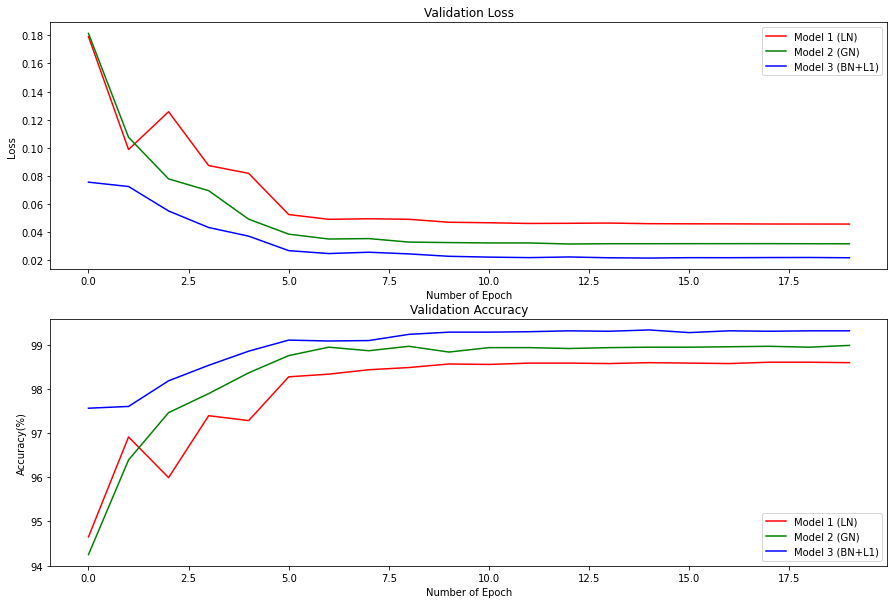

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,10))
axs[0].plot(test_losses1, color='red', label='Model 1 (LN)')
axs[0].plot(test_losses2, color='green', label='Model 2 (GN)')
axs[0].plot(test_losses3, color='blue', label='Model 3 (BN+L1)')
axs[0].set_title("Validation Loss")
axs[0].set_xlabel('Number of Epoch')
axs[0].set_ylabel('Loss')
axs[1].plot(test_acc1, color='red', label='Model 1 (LN)')
axs[1].plot(test_acc2, color='green', label='Model 2 (GN)')
axs[1].plot(test_acc3, color='blue', label='Model 3 (BN+L1)')
axs[1].set_title("Validation Accuracy")
axs[1].set_xlabel('Number of Epoch')
axs[1].set_ylabel('Accuracy(%)')
axs[0].legend(loc='upper right')
axs[1].legend(loc='lower right')

In [ ]:
# Function to Plot the Misclassified Images of the Network
def plot_misclassified_images(incorrect_predictions):
  fig = plt.figure(figsize=(20, 10))
  for index, dataset in enumerate(incorrect_predictions[:10], start=1):
    plt.subplot(5, 2, index)
    plt.axis('off')
    plt.title(f'Model Prediction : {incorrect_predictions[index-1][1]}, Actual Label : {incorrect_predictions[index-1][2]}')
    plt.imshow(incorrect_predictions[index - 1][0].to('cpu').numpy().squeeze(), cmap='gray_r')

10 Misclassified Images of Model 1(Layer Normalisation)

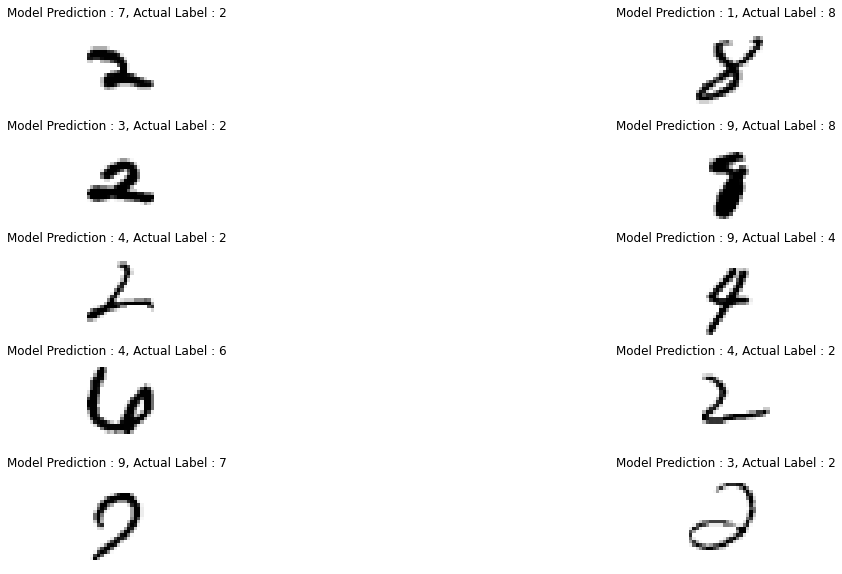

In [ ]:
plot_misclassified_images(incorrect_prediction1)

10 Misclassified Images of Model 2(Group Normalisation)

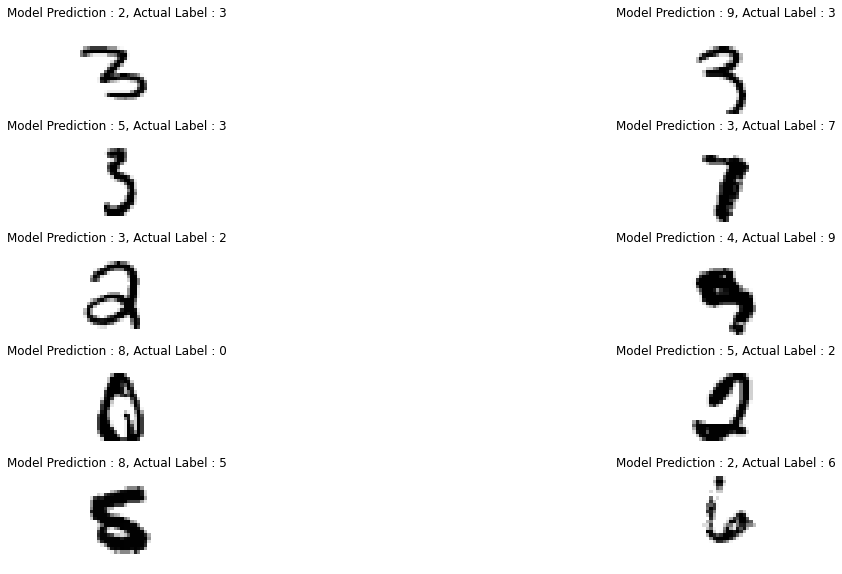

In [ ]:
plot_misclassified_images(incorrect_prediction2)

10 Misclassified Images of Model 3(Batch Normalisation + L1 Regularizer)

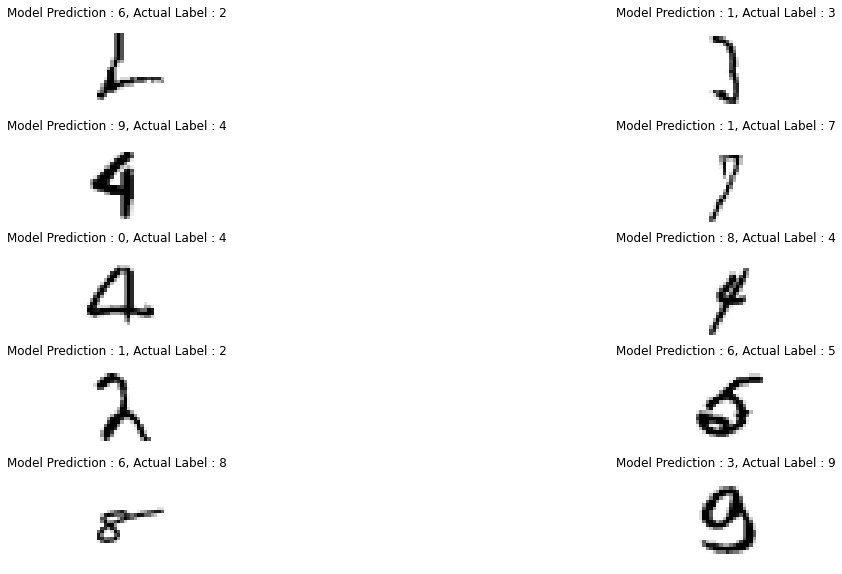

In [ ]:
plot_misclassified_images(incorrect_prediction3)